# Tutorial associated to the journal paper about SMFCK using the Rosenbrock functions

Authors: Mauricio Castano Aguirre UPHF/LAMIH-ONERA/DTIS/M2CI.

Update: Feb. 2026

### Version SMT 2.10.1

In [4]:
# %pip install smt

Training time SMFCK non-nested = 1.988084077835083


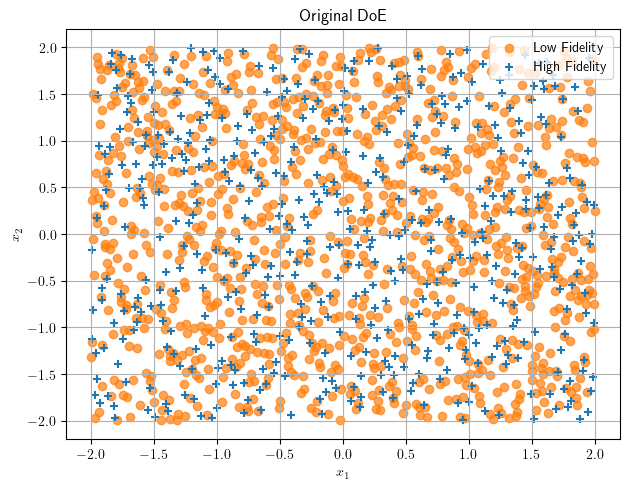

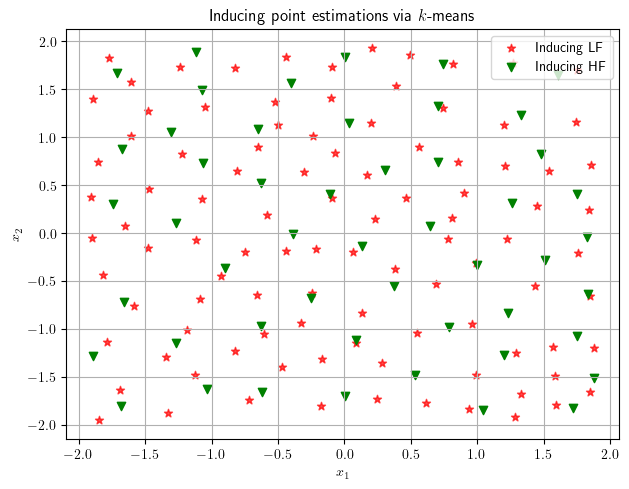

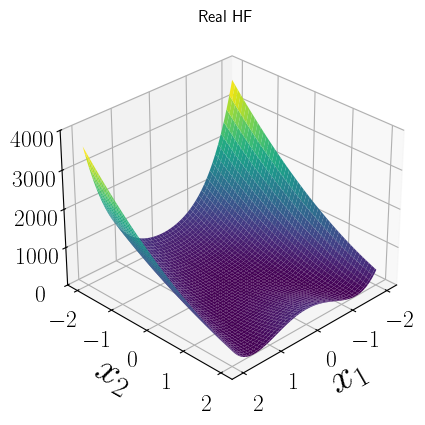

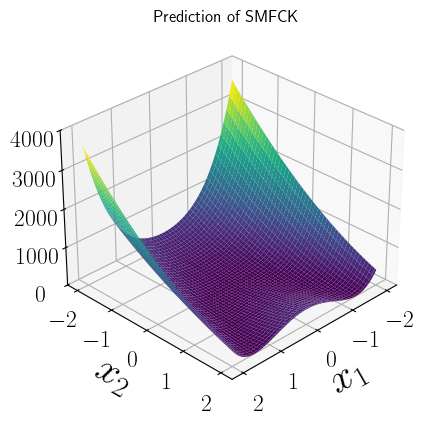

\begin{table}
\caption{Performance of SMFCK Model using Rosenbrock functions}
\begin{tabular}{lrr}
\toprule
Metric & Mean Nested DoE & Std Dev DoE-Nested \\
\midrule
SMFCK-non HF & 0.241751 & 0.000000 \\
SMFCK-non LF & 0.109334 & 0.000000 \\
\bottomrule
\end{tabular}
\end{table}



In [5]:
from smt.applications import SMFCK
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from smt.sampling_methods import LHS

plt.rcParams["text.usetex"] = True
font_size = 30
font_legend = 20
label_size = 17


def Rosen_HF(points):
    """
    High-fidelity function f2.
    """
    return np.sum(
        100 * (points[:, 1:] - points[:, :-1] ** 2) ** 2 + (1 - points[:, :-1]) ** 2,
        axis=1,
    )


def Rosen_MF(points):
    """
    Medium-fidelity function f1.
    """
    sum_term = np.sum(
        50 * (points[:, 1:] - points[:, :-1] ** 2) ** 2 + (-2 - points[:, :-1]) ** 2,
        axis=1,
    )
    penalty_term = 0.5 * np.sum(points[:, :-1], axis=1)
    return sum_term - penalty_term


def Rosen_LF(points):
    """
    Low-fidelity function f0.
    """
    f2_values = Rosen_HF(points)
    penalty_term = 4 + 0.5 * np.sum(points, axis=1)
    denominator = 10 + 0.25 * np.sum(points, axis=1)
    return (f2_values - penalty_term) / denominator


def add_noise(y, noise_level=0.1):
    return y + np.random.normal(0, noise_level, y.shape)


N_max_reps = 1


xlimits = np.array([[-2.0, 2.0], [-2.0, 2.0]])  # Range for each dimension

num_samples = 512

rmsehfmfck_list = []
rmselfmfck_list = []


rmsehfsmfck_non_list = []
rmselfsmfck_non_list = []


rmsehfmfk_list = []


rmselfmfk_list = []

i = 0

N_hf = 512
N_lf = 1024

inducing_lf = 100
inducing_hf = 50
n_start = 10
hyper_opt = "Cobyla-nlopt"
method = "VFE"
theta0 = np.array([[2.0], [5.0]])
theta_bounds = [1e-2, 100]
rho_bounds = [1.0, 5.0]
sigma_bounds = [1e-2, 100]
noise_bounds = [1e-8, 100]


for rnd_state in range(N_max_reps):
    sampling_non_nested = LHS(
        xlimits=xlimits,
        criterion="ese",
        seed=1,
    )
    X_HF_non_nested = sampling_non_nested(N_hf)
    X_LF_non_nested = sampling_non_nested(N_lf)

    z_HF_non_nested = Rosen_HF(X_HF_non_nested)
    # z_MF = Rosen_MF(x_MF)
    z_LF_non_nested = Rosen_LF(X_LF_non_nested)

    z_HF_non_nested = add_noise(z_HF_non_nested, noise_level=0.2)
    z_LF_non_nested = add_noise(z_LF_non_nested, noise_level=0.4)

    # Test set
    num = 100
    x = np.linspace(xlimits[0][0], xlimits[0][1], num)
    y = np.linspace(xlimits[1][0], xlimits[1][1], num)
    xv, yv = np.meshgrid(x, y)
    x_test = np.array([np.ravel(xv), np.ravel(yv)]).T

    z_test_LF = np.zeros([num * num, 1])
    z_test_LF = Rosen_LF(x_test)

    z_test_HF = np.zeros([num * num, 1])
    z_test_HF = Rosen_HF(x_test)

    smfckn = SMFCK(
        hyper_opt=hyper_opt,
        method=method,
        theta0=[1.0],
        print_global=False,
        eval_noise=True,
        noise0=[1e-3],
        noise_bounds=noise_bounds,
        theta_bounds=theta_bounds,
        n_start=n_start,
        inducing_method="kmeans",
        sigma_bounds=sigma_bounds,
        rho_bounds=rho_bounds,
        n_inducing=[inducing_lf, inducing_hf],
    )

    smfckn.set_training_values(X_LF_non_nested, z_LF_non_nested, name=0)
    # mfck1.set_training_values(x_MF, z_MF, name=1)
    smfckn.set_training_values(X_HF_non_nested, z_HF_non_nested)

    start = time.time()
    smfckn.train()
    end = time.time()
    print("Training time SMFCK non-nested =", end - start)

    meansn, covariancesn = smfckn.predict_all_levels(x_test)

    if i == 0:
        plt.figure()
        plt.scatter(
            X_LF_non_nested[:, 0],
            X_LF_non_nested[:, 1],
            color="C1",
            marker="o",
            alpha=0.7,
            label="Low Fidelity",
        )
        plt.scatter(
            X_HF_non_nested[:, 0],
            X_HF_non_nested[:, 1],
            color="C0",
            marker="+",
            alpha=1.0,
            label="High Fidelity",
        )
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.tight_layout()
        plt.title("Original DoE")
        plt.show()

        plt.figure()
        plt.scatter(
            smfckn.Z[0][:, 0],
            smfckn.Z[0][:, 1],
            color="red",
            marker="*",
            alpha=0.7,
            label="Inducing LF",
        )
        plt.scatter(
            smfckn.Z[1][:, 0],
            smfckn.Z[1][:, 1],
            color="green",
            marker="v",
            alpha=1.0,
            label="Inducing HF",
        )
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.tight_layout()
        plt.title("Inducing point estimations via $k$-means")
        plt.show()
        i = 1

    # Define the common z-axis limits
    z_min = min(z_LF_non_nested.min(), z_HF_non_nested.min())
    z_max = max(z_LF_non_nested.max(), z_HF_non_nested.max())

    z_min = 0
    z_max = 4000

    fig = plt.figure()
    # f2 plot
    ax2 = fig.add_subplot(111, projection="3d")
    ax2.plot_surface(
        xv, yv, z_test_HF.reshape(-1, num), cmap="viridis", edgecolor="none"
    )
    # ax2.set_title(r"$f_0(x_1,x_2)$",fontsize=font_size)
    ax2.set_xlabel("$x_1$", fontsize=font_size)
    ax2.set_ylabel("$x_2$", fontsize=font_size)

    ax2.tick_params(axis="x", labelsize=label_size)
    ax2.tick_params(axis="y", labelsize=label_size)
    ax2.tick_params(axis="z", labelsize=label_size)

    ax2.set_zlim(z_min, z_max)
    ax2.view_init(elev=30, azim=45)  # Set the perspective for f1
    plt.title("Real HF")
    plt.show()

    # f2 plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_surface(
        xv, yv, meansn[1].reshape(-1, num), cmap="viridis", edgecolor="none"
    )
    # ax3.set_title(r"$m_{mfck}$",fontsize=font_size)
    ax.set_xlabel("$x_1$", fontsize=font_size)
    ax.set_ylabel("$x_2$", fontsize=font_size)

    ax.tick_params(axis="x", labelsize=label_size)
    ax.tick_params(axis="y", labelsize=label_size)
    ax.tick_params(axis="z", labelsize=label_size)

    ax.set_zlim(z_min, z_max)
    ax.view_init(elev=30, azim=45)  # Set the perspective for f1
    plt.title("Prediction of SMFCK")
    plt.show()

    rmsesmfck_non_lf = np.sqrt(np.mean((z_test_LF - meansn[0][:, 0]) ** 2))
    rmsesmfck_non_hf = np.sqrt(np.mean((z_test_HF - meansn[1][:, 0]) ** 2))

    rmsehfsmfck_non_list.append(rmsesmfck_non_hf)
    rmselfsmfck_non_list.append(rmsesmfck_non_lf)


rmse_data = [rmsehfsmfck_non_list, rmselfsmfck_non_list]

data = {
    "Metric": ["SMFCK-non HF", "SMFCK-non LF"],
    "Mean Nested DoE": np.mean(rmse_data, axis=1),
    "Std Dev DoE-Nested": np.std(rmse_data, axis=1),
}

df = pd.DataFrame(data)
latex_table = df.to_latex(
    index=False, caption="Performance of SMFCK Model using Rosenbrock functions"
)
print(latex_table)